## Importing Libraries and Loading Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import os
import h5py
import matplotlib.image as mpimg
import IPython.display as ipd
import librosa

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [2]:
data = pd.read_csv("dataset.csv")
print(data.head())

                       IMAGE     mfcc_1     mfcc_2     mfcc_3     mfcc_4  \
0  images/forest/forest0.png  15.795384  -3.442518 -25.316836 -33.412104   
1  images/forest/forest1.png  15.883880  -3.494075 -21.189490 -18.077115   
2  images/forest/forest2.png  17.872629 -18.877467 -31.665319 -47.045579   
3  images/forest/forest3.png  16.843997  -3.527753 -21.282970 -24.248141   
4  images/forest/forest4.png  16.128583  -4.267328 -25.608325 -20.231084   

      mfcc_5     mfcc_6     mfcc_7     mfcc_8     mfcc_9  ...    mfcc_97  \
0   2.447290 -46.981182  12.889984 -23.588534 -22.625879  ... -43.876462   
1   4.284962 -27.014271   3.666955  -9.091312  -3.746509  ... -33.883092   
2   1.813430 -45.899877  14.975982 -24.462396  -1.812962  ... -34.456028   
3  27.201589 -18.787674  30.093938  -1.922008  10.156418  ... -36.410615   
4  15.922823 -35.703313  16.307644  -3.547505   4.804142  ... -41.548915   

     mfcc_98    mfcc_99   mfcc_100   mfcc_101   mfcc_102   mfcc_103  \
0  20.697491 -2

## Visualizing CLASS1 and CLASS2 Distribution with Pie Charts

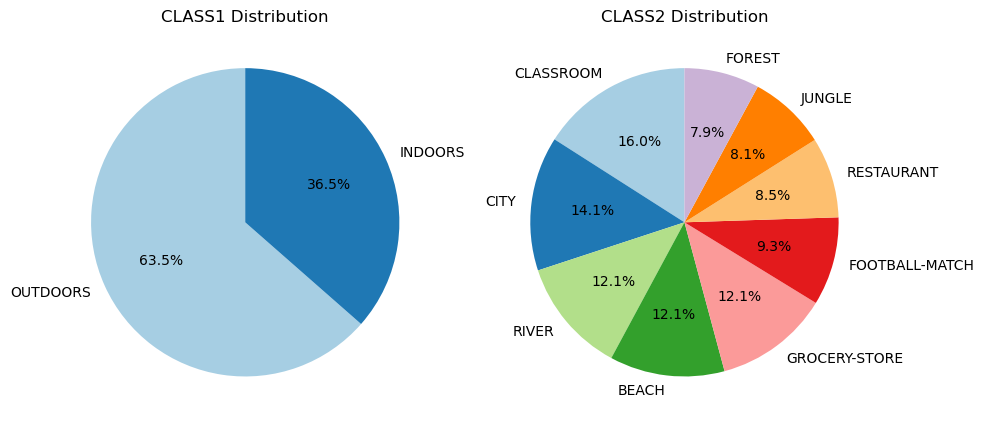

In [3]:
plt.figure(figsize=(10, 5))

# CLASS1 Distribution
plt.subplot(1, 2, 1)
class1_counts = data['CLASS1'].value_counts()
plt.pie(class1_counts, labels=class1_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('CLASS1 Distribution')

# CLASS2 Distribution
plt.subplot(1, 2, 2)
class2_counts = data['CLASS2'].value_counts()
plt.pie(class2_counts, labels=class2_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('CLASS2 Distribution')

plt.tight_layout()
plt.show()

### Preparing Data and Features for Audio and Images

In [4]:
data['CLASS1'] = data['CLASS1'].astype('category').cat.codes
data['CLASS2'] = data['CLASS2'].astype('category').cat.codes

In [5]:
mfcc_columns = [col for col in data.columns if 'mfcc' in col]
audio_features = data[mfcc_columns].replace('[^.0-9-]', '', regex=True).astype(float).values

In [6]:
optimized_file = "image_features_optimized.h5"

print("Loading optimized features...")
with h5py.File(optimized_file, 'r') as hf:
    image_features_optimized = hf['features'][:]
print(f"Optimized features shape: {image_features_optimized.shape}")

scaler = StandardScaler()
image_features_scaled = scaler.fit_transform(image_features_optimized)
audio_features_scaled = scaler.fit_transform(audio_features)

Loading optimized features...
Optimized features shape: (17252, 512)


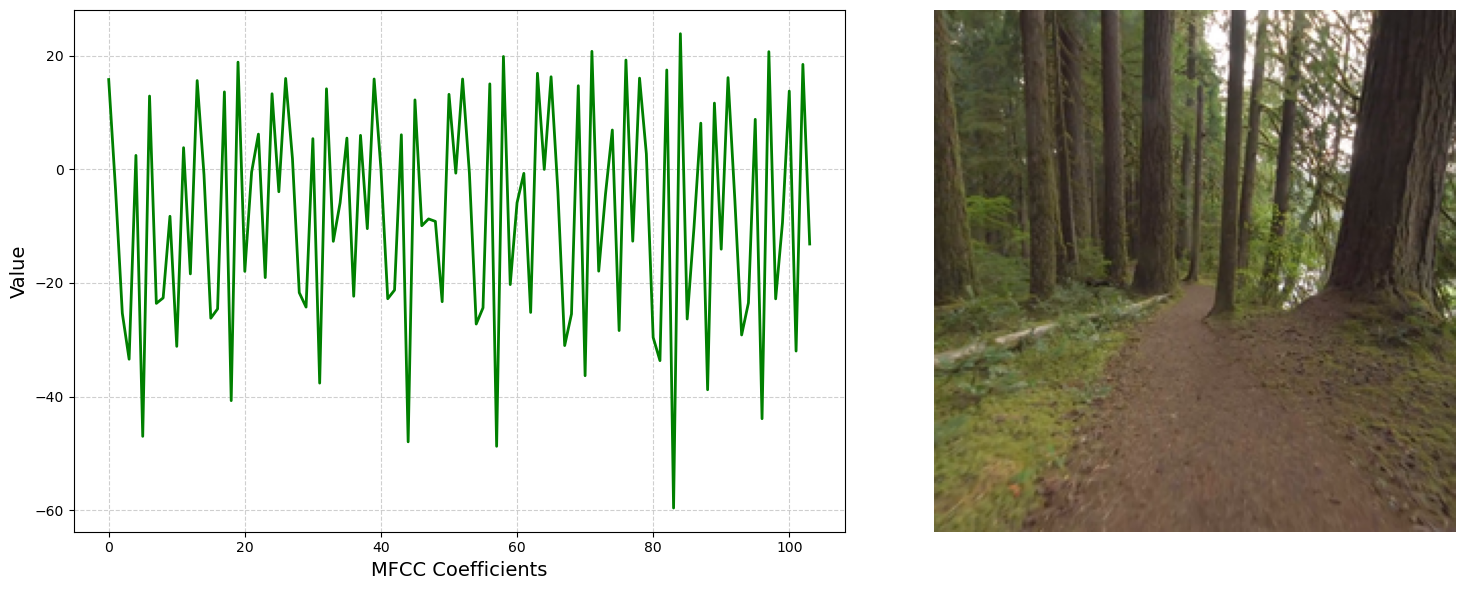

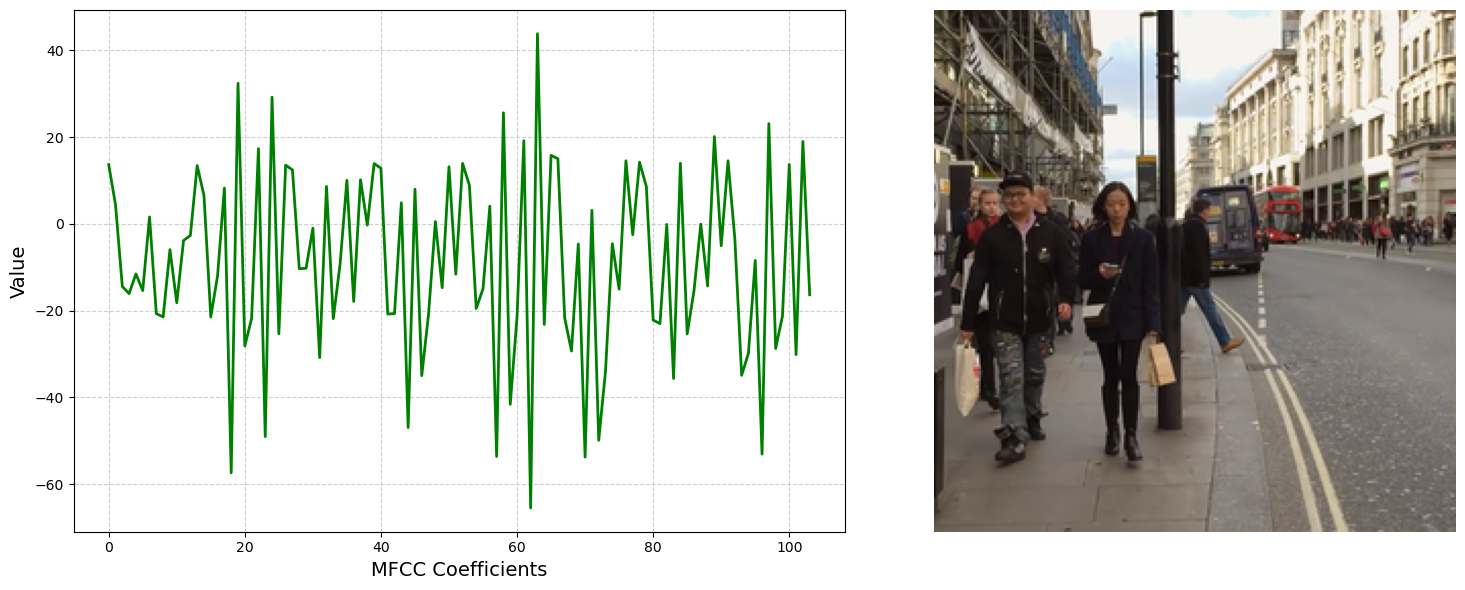

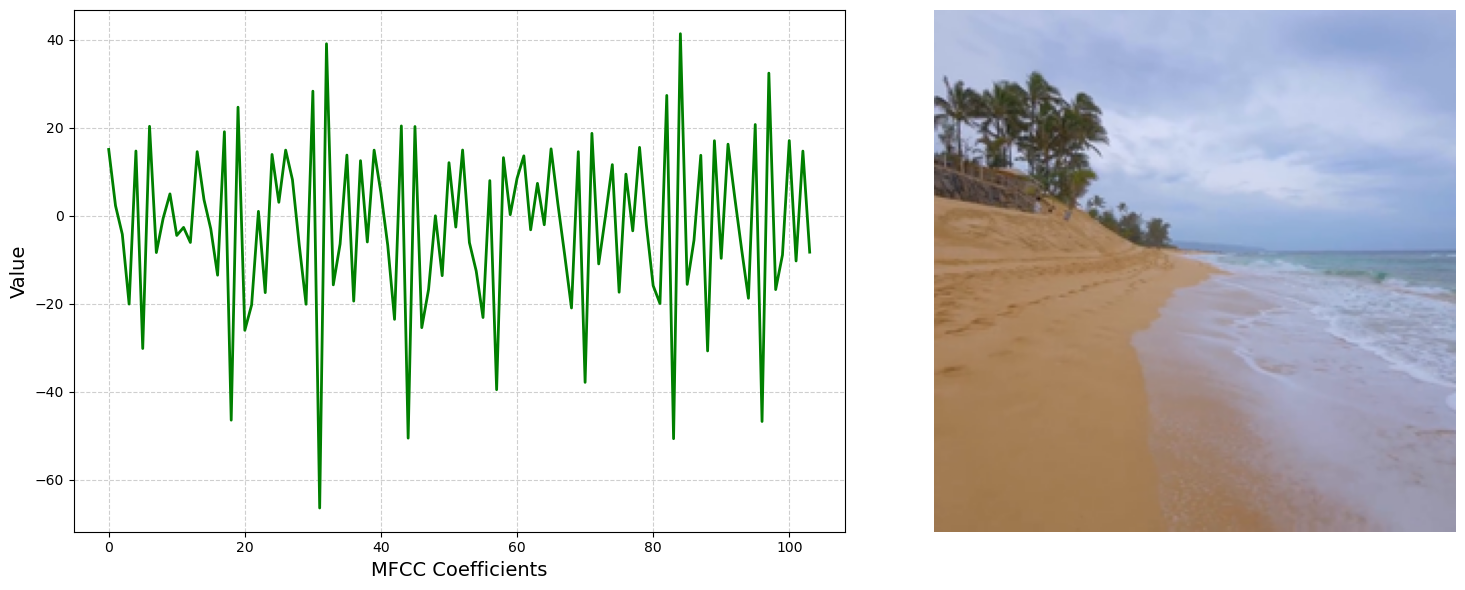

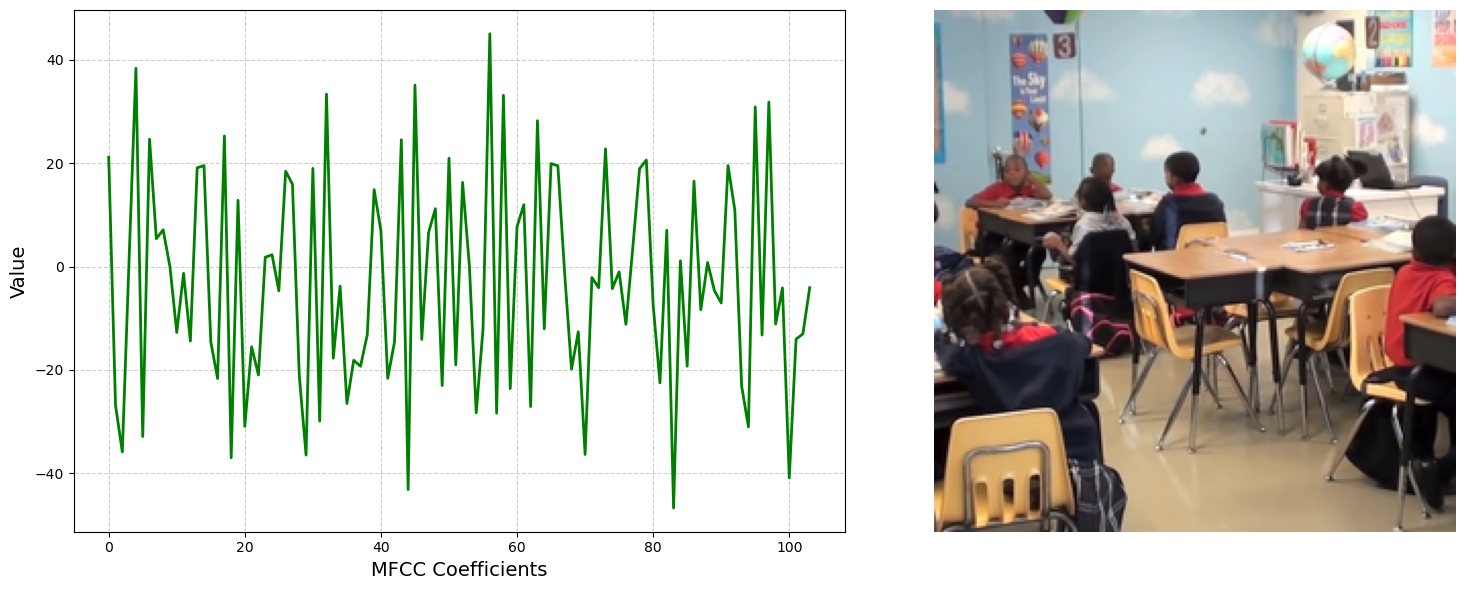

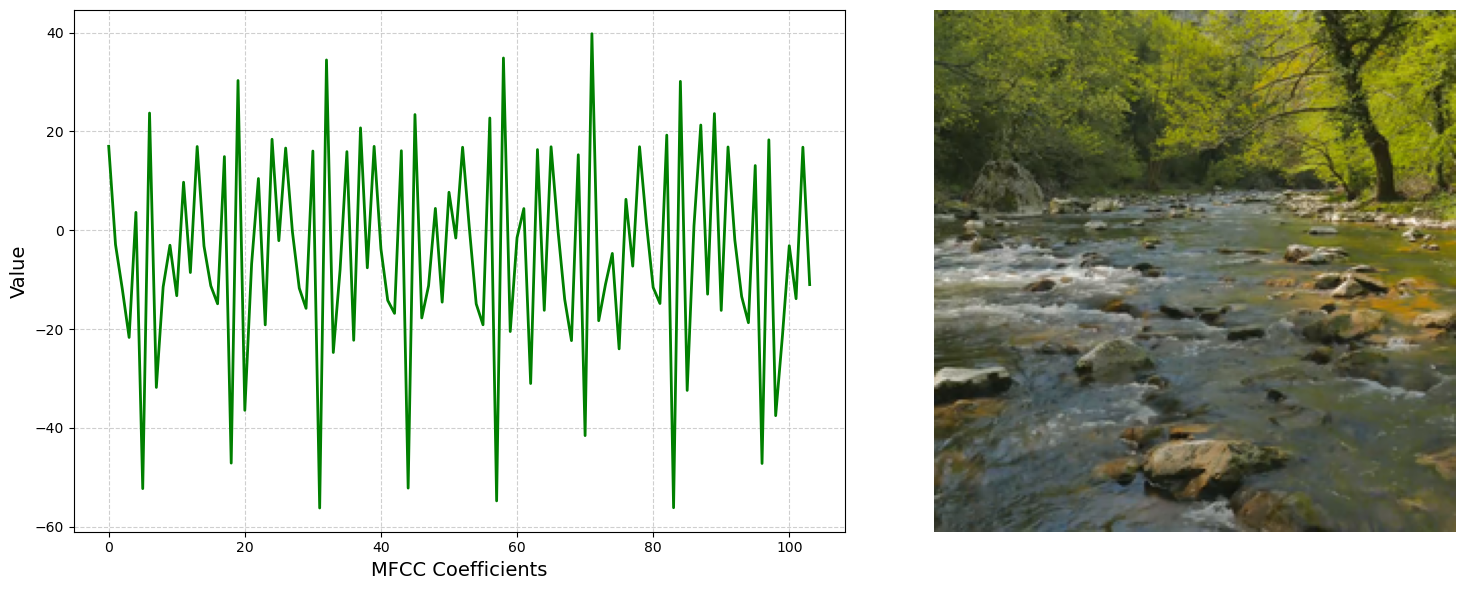

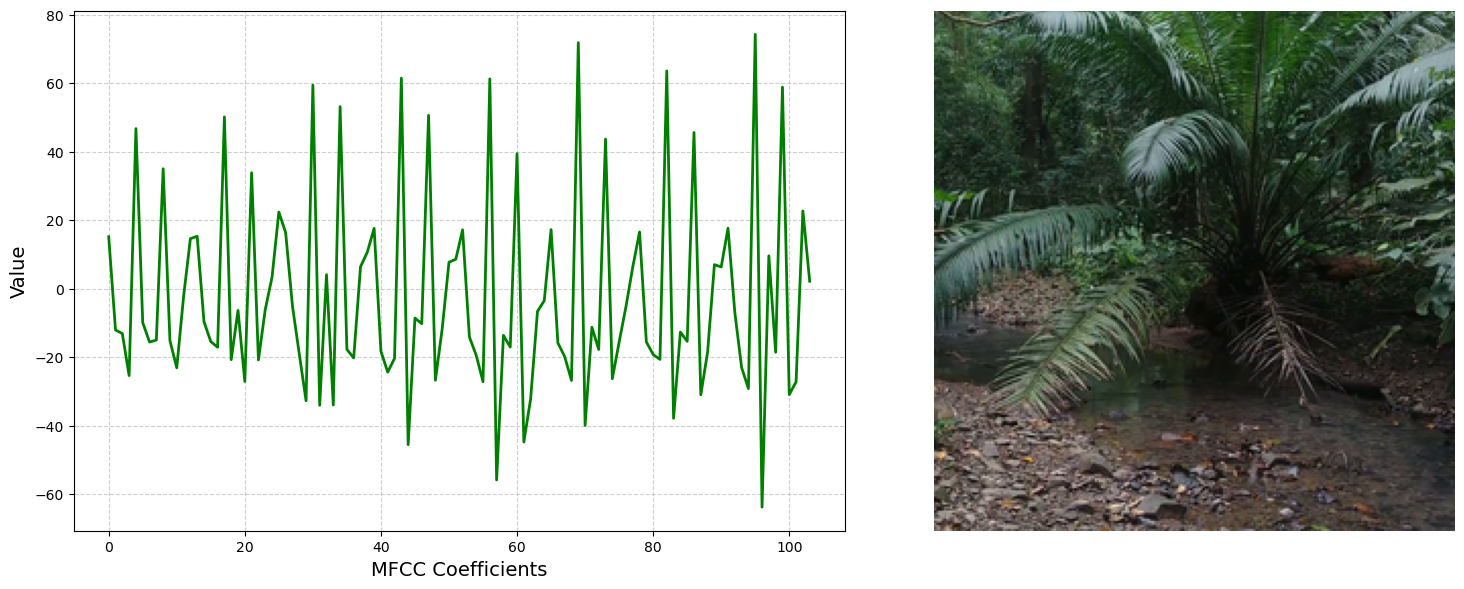

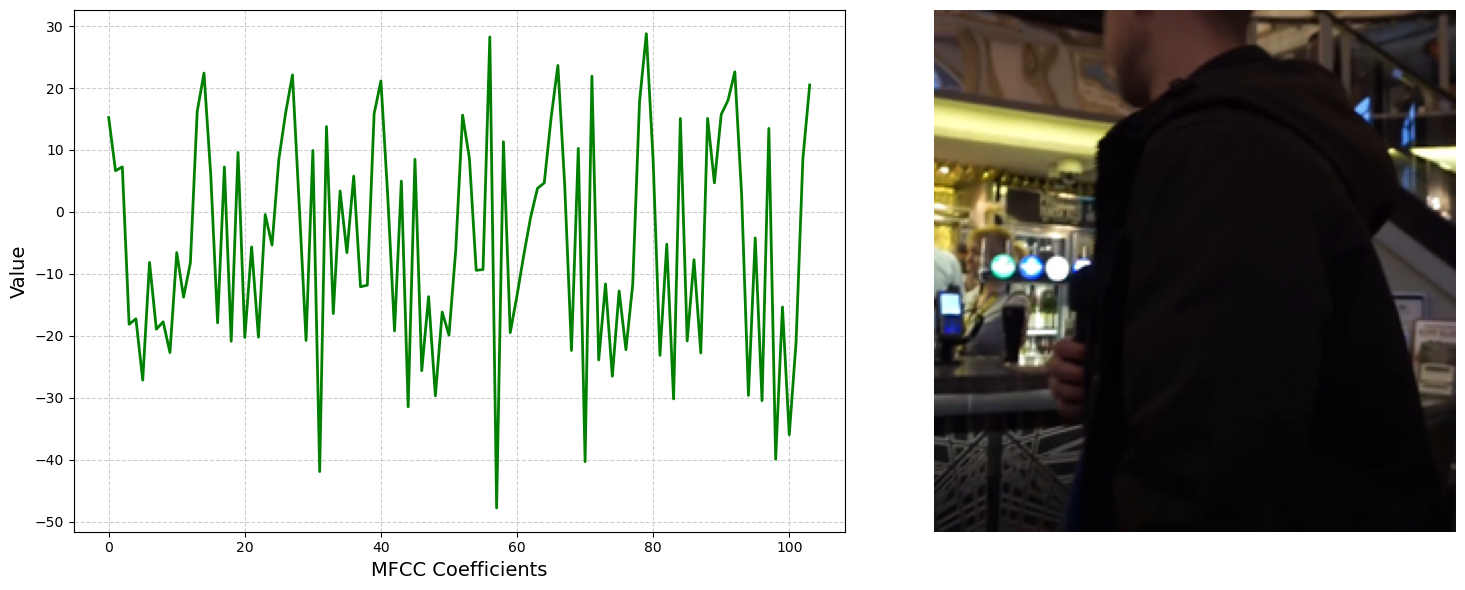

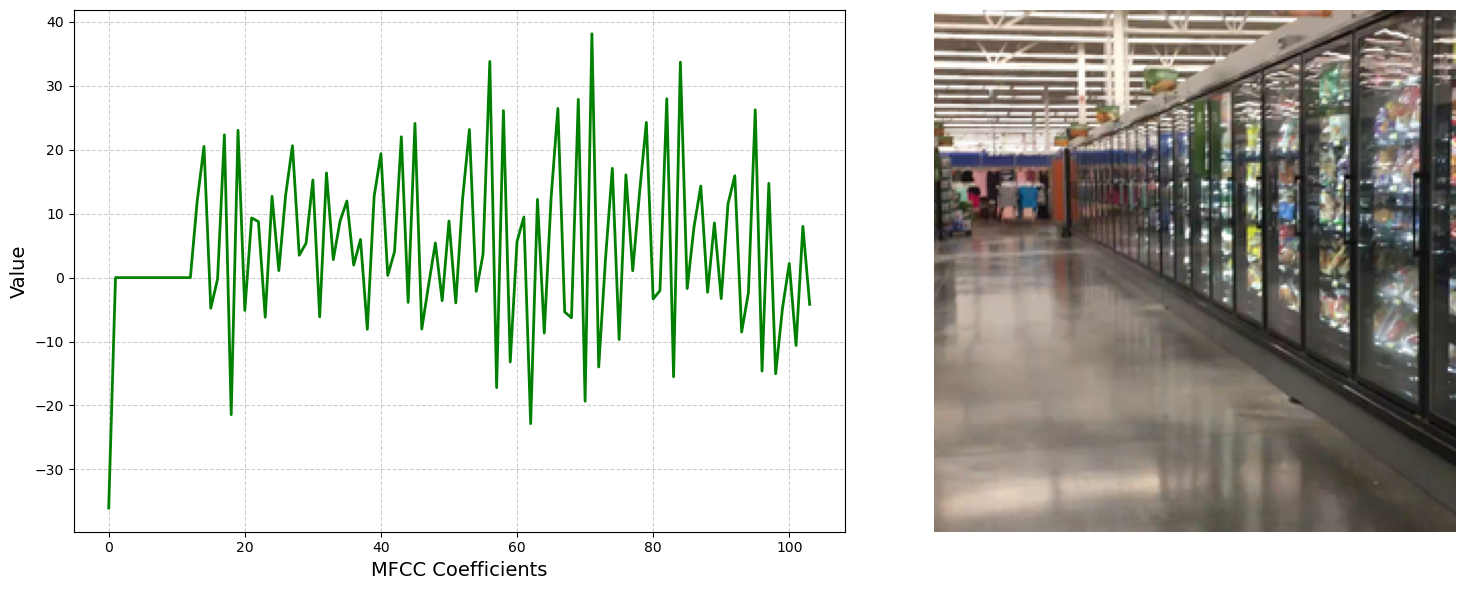

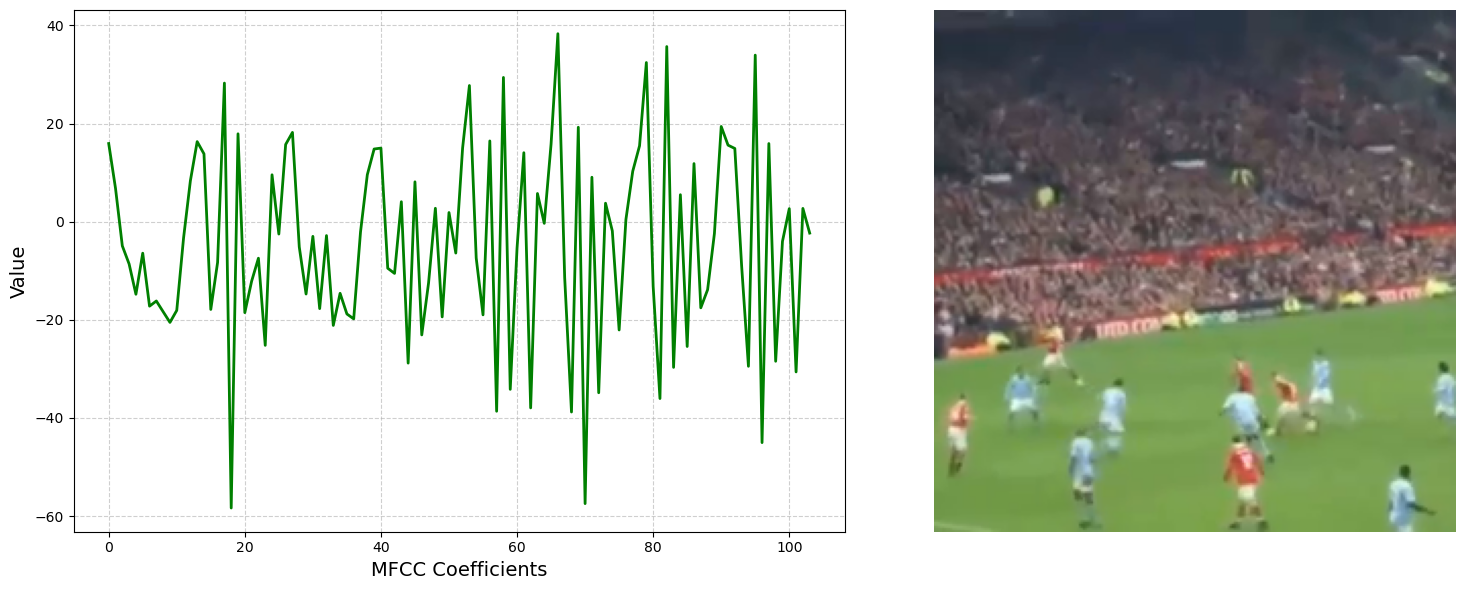

In [7]:
unique_classes = data['CLASS2'].unique()
class2_mapping = dict(enumerate(data['CLASS2'].astype('category').cat.categories))

for class_value in unique_classes:
    class_data = data[data['CLASS2'] == class_value]
    first_row = class_data.iloc[0]

    mfcc_values = first_row[mfcc_columns].values.astype(float)
    image_path = first_row['IMAGE']
    class_label = class2_mapping[class_value]

    if os.path.exists(image_path):
        img = mpimg.imread(image_path)

        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        axes[0].plot(mfcc_values, color='green', linewidth=2)
        axes[0].set_xlabel("MFCC Coefficients", fontsize=14)
        axes[0].set_ylabel("Value", fontsize=14)
        axes[0].grid(True, linestyle='--', alpha=0.6)

        axes[1].imshow(img)
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

## Splitting Data

###  Saving and loading extracted image features using HDF5

In [8]:
image_features_scaled = scaler.fit_transform(image_features_optimized)
audio_features_scaled = scaler.fit_transform(audio_features)
combined_features_scaled = np.hstack([image_features_scaled, audio_features_scaled])

In [9]:
X_train_audio, X_test_audio, y_train_audio_class1, y_test_audio_class1 = train_test_split(
    audio_features_scaled, data['CLASS1'], test_size=0.2, random_state=42
)

X_train_audio, X_test_audio, y_train_audio_class2, y_test_audio_class2 = train_test_split(
    audio_features_scaled, data['CLASS2'], test_size=0.2, random_state=42
)

X_train_image, X_test_image, y_train_image_class1, y_test_image_class1 = train_test_split(
    image_features_scaled, data['CLASS1'], test_size=0.2, random_state=42
)

X_train_image, X_test_image, y_train_image_class2, y_test_image_class2 = train_test_split(
    image_features_scaled, data['CLASS2'], test_size=0.2, random_state=42
)

X_train_combined, X_test_combined, y_train_combined_class1, y_test_combined_class1 = train_test_split(
    combined_features_scaled, data['CLASS1'], test_size=0.2, random_state=42
)

X_train_combined, X_test_combined, y_train_combined_class2, y_test_combined_class2 = train_test_split(
    combined_features_scaled, data['CLASS2'], test_size=0.2, random_state=42
)


### Training and Evaluating Model with ROC Curve Visualization

In [10]:
def train_evaluate_and_plot(X_train, X_test, y_train, y_test, label):
    # Train Decision Tree Classifier
    model = DecisionTreeClassifier(max_depth=12, random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Classification Report and Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    classification = classification_report(y_test, y_pred, zero_division=0)
    print(f"{label} Accuracy: {accuracy:.2f}")
    print(f"{label} Classification Report:\n{classification}")

    # ROC Curve
    if hasattr(model, "predict_proba") and len(np.unique(y_test)) == 2:
        y_score = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="--")
        plt.plot(fpr, tpr, color="orange", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
        plt.title(f'ROC Curve for {label}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()

    # T-SNE Visualization
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_results = tsne.fit_transform(X_test)

    tsne_plot = plt.figure(figsize=(10, 6))
    ax = tsne_plot.add_subplot(111)
    for unique_label in np.unique(y_test):
        indices = np.where(y_test == unique_label)
        ax.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=f'Class {unique_label}', alpha=0.7)
    ax.legend()

    plt.close(tsne_plot)
    return tsne_plot

# Decision tree

# Sound

Audio CLASS1 Accuracy: 0.81
Audio CLASS1 Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.76      0.74      1240
           1       0.86      0.84      0.85      2211

    accuracy                           0.81      3451
   macro avg       0.80      0.80      0.80      3451
weighted avg       0.81      0.81      0.81      3451



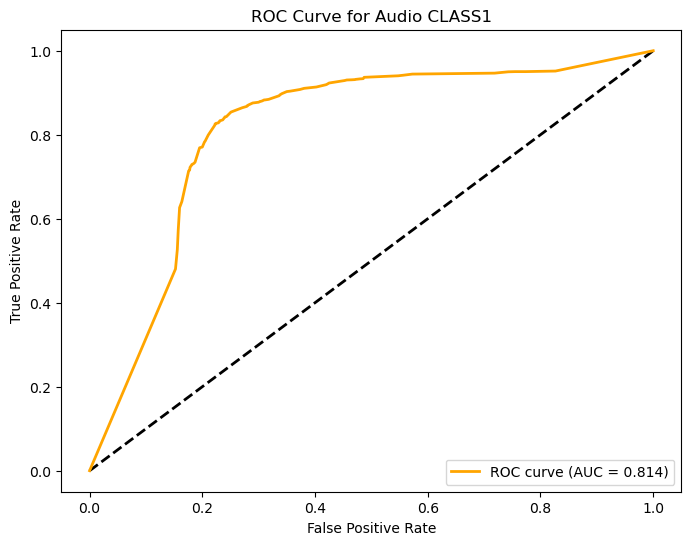

Audio CLASS2 Accuracy: 0.66
Audio CLASS2 Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       404
           1       0.55      0.48      0.51       500
           2       0.76      0.72      0.74       527
           3       0.78      0.73      0.75       334
           4       0.87      0.77      0.82       271
           5       0.57      0.65      0.61       407
           6       0.93      0.92      0.93       275
           7       0.42      0.57      0.49       306
           8       0.56      0.54      0.55       427

    accuracy                           0.66      3451
   macro avg       0.68      0.67      0.67      3451
weighted avg       0.67      0.66      0.66      3451



In [11]:
audio_dt_class_1 = train_evaluate_and_plot(X_train_audio, X_test_audio, y_train_audio_class1, y_test_audio_class1, "Audio CLASS1")
audio_dt_class_2 = train_evaluate_and_plot(X_train_audio, X_test_audio, y_train_audio_class2, y_test_audio_class2, "Audio CLASS2")

## Image

Combined CLASS1 Accuracy: 0.97
Combined CLASS1 Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1240
           1       0.98      0.97      0.97      2211

    accuracy                           0.97      3451
   macro avg       0.96      0.97      0.96      3451
weighted avg       0.97      0.97      0.97      3451



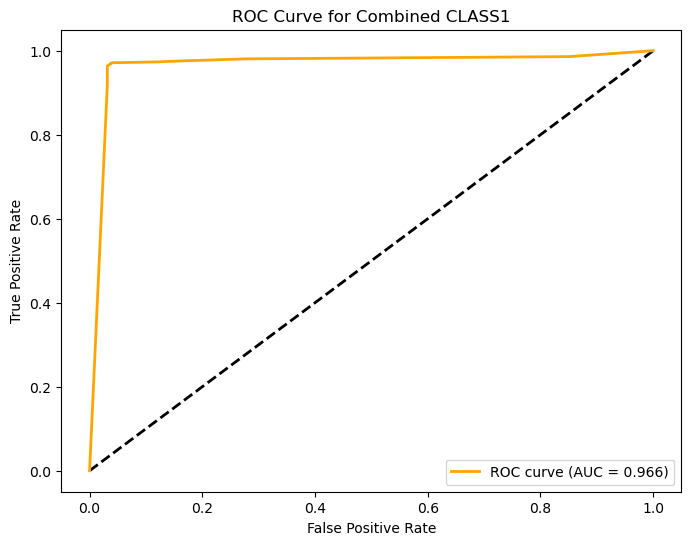

Combined CLASS2 Accuracy: 0.92
Combined CLASS2 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       404
           1       0.92      0.87      0.90       500
           2       0.91      0.97      0.94       527
           3       0.95      0.93      0.94       334
           4       0.96      0.96      0.96       271
           5       0.90      0.86      0.88       407
           6       0.94      0.95      0.94       275
           7       0.79      0.84      0.81       306
           8       0.92      0.92      0.92       427

    accuracy                           0.92      3451
   macro avg       0.92      0.92      0.92      3451
weighted avg       0.92      0.92      0.92      3451



In [12]:
image_dt_class_1 = train_evaluate_and_plot(X_train_image, X_test_image, y_train_image_class1, y_test_image_class1, "Combined CLASS1")
image_dt_class_2 = train_evaluate_and_plot(X_train_image, X_test_image, y_train_image_class2, y_test_image_class2, "Combined CLASS2")

# Multimodal ML with Audio and Images Combined

Combined CLASS1 Accuracy: 0.96
Combined CLASS1 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1240
           1       0.98      0.97      0.97      2211

    accuracy                           0.96      3451
   macro avg       0.96      0.96      0.96      3451
weighted avg       0.97      0.96      0.97      3451



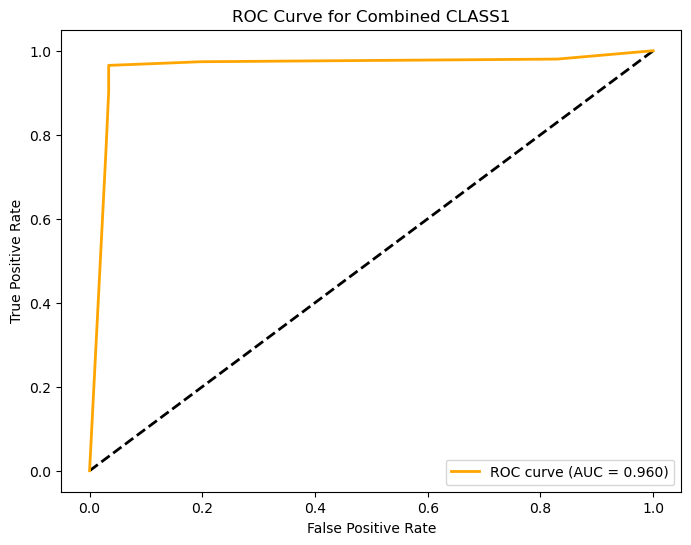

Combined CLASS2 Accuracy: 0.92
Combined CLASS2 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       404
           1       0.92      0.90      0.91       500
           2       0.97      0.96      0.97       527
           3       0.95      0.94      0.94       334
           4       0.95      0.96      0.95       271
           5       0.89      0.90      0.90       407
           6       0.97      0.96      0.96       275
           7       0.76      0.84      0.80       306
           8       0.92      0.89      0.91       427

    accuracy                           0.92      3451
   macro avg       0.92      0.92      0.92      3451
weighted avg       0.92      0.92      0.92      3451



In [13]:
combined_dt_class_1 = train_evaluate_and_plot(X_train_combined, X_test_combined, y_train_combined_class1, y_test_combined_class1, "Combined CLASS1")
combined_dt_class_2 = train_evaluate_and_plot(X_train_combined, X_test_combined, y_train_combined_class2, y_test_combined_class2, "Combined CLASS2")

# Neural Network

In [14]:
def train_evaluate_and_plot_nn(X_train, X_test, y_train, y_test, label):
    # Prepare Data for Neural Network
    y_train_nn = to_categorical(y_train)
    y_test_nn = to_categorical(y_test)

    # Build Neural Network
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(y_train_nn.shape[1], activation='softmax')
    ])

    # Compile the Model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the Model
    history = model.fit(X_train, y_train_nn, validation_split=0.2, epochs=30, batch_size=32, verbose=1)

    # Evaluate the Model
    test_loss, test_accuracy = model.evaluate(X_test, y_test_nn, verbose=0)
    print(f"{label} Test Accuracy: {test_accuracy:.2f}")

    # Plot Training and Validation Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{label} Neural Network Training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # T-SNE Visualization for Predicted Labels
    predicted_labels = np.argmax(model.predict(X_test), axis=1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_results = tsne.fit_transform(X_test)

    tsne_plot_predicted = plt.figure(figsize=(10, 6))
    ax_predicted = tsne_plot_predicted.add_subplot(111)
    for unique_label in np.unique(predicted_labels):
        indices = np.where(predicted_labels == unique_label)
        ax_predicted.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=f'Class {unique_label}', alpha=0.7)
    ax_predicted.legend()
    plt.close(tsne_plot_predicted)

    # T-SNE Visualization for Real Labels
    tsne_plot_real = plt.figure(figsize=(10, 6))
    ax_real = tsne_plot_real.add_subplot(111)
    for unique_label in np.unique(y_test):
        indices = np.where(y_test == unique_label)
        ax_real.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=f'Class {unique_label}', alpha=0.7)
    ax_real.legend()
    plt.close(tsne_plot_real)

    return tsne_plot_predicted, tsne_plot_real

## Audio

C:\Users\pharp\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7796 - loss: 0.4636 - val_accuracy: 0.9076 - val_loss: 0.2357
Epoch 2/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9005 - loss: 0.2482 - val_accuracy: 0.9218 - val_loss: 0.1915
Epoch 3/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9195 - loss: 0.2028 - val_accuracy: 0.9337 - val_loss: 0.1642
Epoch 4/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9380 - loss: 0.1701 - val_accuracy: 0.9399 - val_loss: 0.1544
Epoch 5/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9421 - loss: 0.1539 - val_accuracy: 0.9464 - val_loss: 0.1382
Epoch 6/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9502 - loss: 0.1365 - val_accuracy: 0.9468 - val_loss: 0.1327
Epoch 7/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9520 - loss: 0.1305 - val_accuracy: 0.9497 - val_loss: 0.1342
Epoch 8/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9559 - loss: 0.1213 - val_accuracy: 0.

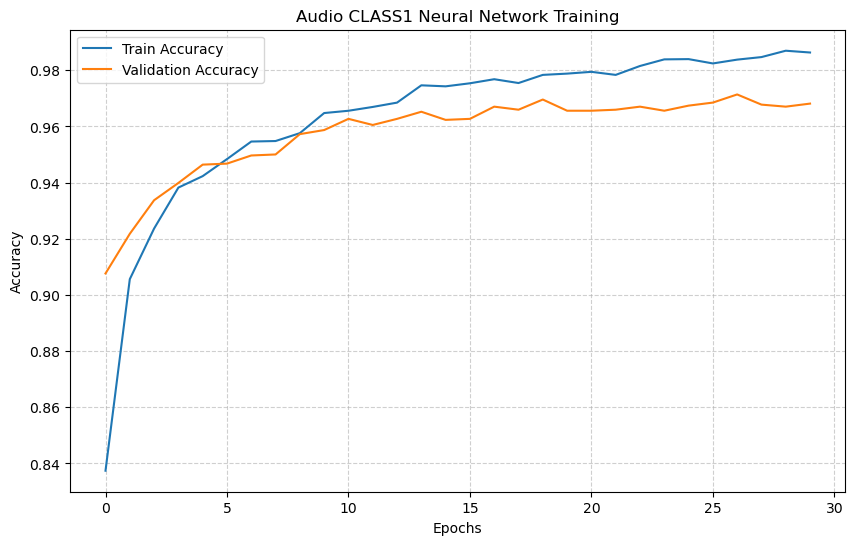

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/30


C:\Users\pharp\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


345/345 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4325 - loss: 1.6398 - val_accuracy: 0.7885 - val_loss: 0.6743
Epoch 2/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7413 - loss: 0.8032 - val_accuracy: 0.8450 - val_loss: 0.4968
Epoch 3/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8006 - loss: 0.6263 - val_accuracy: 0.8729 - val_loss: 0.3924
Epoch 4/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8275 - loss: 0.5233 - val_accuracy: 0.8888 - val_loss: 0.3462
Epoch 5/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8492 - loss: 0.4576 - val_accuracy: 0.8921 - val_loss: 0.3235
Epoch 6/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8597 - loss: 0.4157 - val_accuracy: 0.9033 - val_loss: 0.2989
Epoch 7/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8687 - loss: 0.3852 - val_accuracy: 0.9051 - val_loss: 0.2897
Epoch 8/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8788 - loss: 0.3590 - val_accuracy: 0.9149 - val_

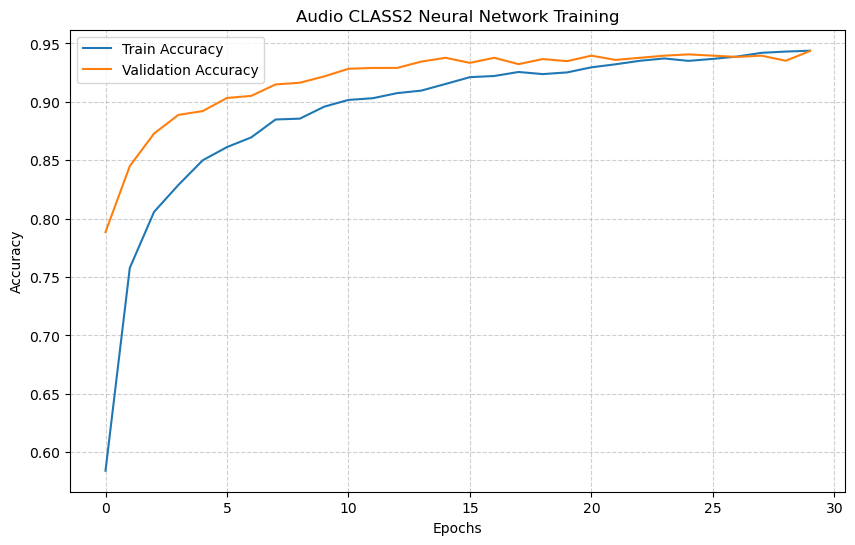

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [15]:
audio_nn_class_1_pred, audio_nn_class_1_real = train_evaluate_and_plot_nn(
    X_train_audio, X_test_audio, y_train_audio_class1, y_test_audio_class1, "Audio CLASS1"
)
audio_nn_class_2_pred, audio_nn_class_2_real = train_evaluate_and_plot_nn(
    X_train_audio, X_test_audio, y_train_audio_class2, y_test_audio_class2, "Audio CLASS2"
)

## Image

Epoch 1/30


C:\Users\pharp\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7200 - loss: 0.6305 - val_accuracy: 0.9841 - val_loss: 0.0476
Epoch 2/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9831 - loss: 0.0541 - val_accuracy: 0.9902 - val_loss: 0.0273
Epoch 3/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9917 - loss: 0.0252 - val_accuracy: 0.9906 - val_loss: 0.0227
Epoch 4/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9952 - loss: 0.0146 - val_accuracy: 0.9906 - val_loss: 0.0290
Epoch 5/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9945 - loss: 0.0143 - val_accuracy: 0.9917 - val_loss: 0.0248
Epoch 6/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9965 - loss: 0.0100 - val_accuracy: 0.9895 - val_loss: 0.0396
Epoch 7/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9969 - loss: 0.0102 - val_accuracy: 0.9924 - val_loss: 0.0273
Epoch 8/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9975 - loss: 0.0072 - val_accuracy: 0.9909 - val_

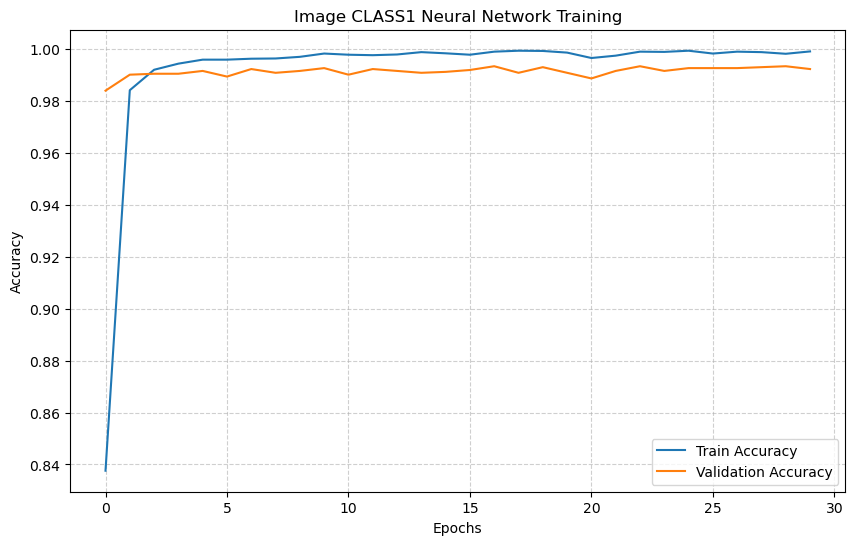

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/30


C:\Users\pharp\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


345/345 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4037 - loss: 1.8073 - val_accuracy: 0.9652 - val_loss: 0.1731
Epoch 2/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9320 - loss: 0.2433 - val_accuracy: 0.9837 - val_loss: 0.0553
Epoch 3/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9713 - loss: 0.0974 - val_accuracy: 0.9877 - val_loss: 0.0383
Epoch 4/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9809 - loss: 0.0611 - val_accuracy: 0.9888 - val_loss: 0.0400
Epoch 5/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9883 - loss: 0.0385 - val_accuracy: 0.9909 - val_loss: 0.0374
Epoch 6/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9899 - loss: 0.0322 - val_accuracy: 0.9906 - val_loss: 0.0345
Epoch 7/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9925 - loss: 0.0237 - val_accuracy: 0.9906 - val_loss: 0.0358
Epoch 8/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9930 - loss: 0.0217 - val_accuracy: 0.9902 - va

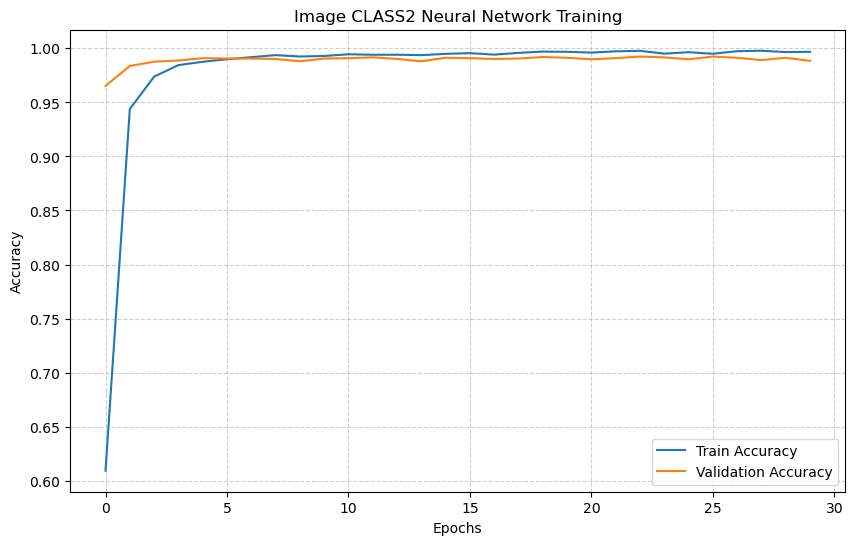

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [16]:
image_nn_class_1_pred, image_nn_class_1_real = train_evaluate_and_plot_nn(
    X_train_image, X_test_image, y_train_image_class1, y_test_image_class1, "Image CLASS1"
)
image_nn_class_2_pred, image_nn_class_2_real = train_evaluate_and_plot_nn(
    X_train_image, X_test_image, y_train_image_class2, y_test_image_class2, "Image CLASS2"
)

## Combined

C:\Users\pharp\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7979 - loss: 0.4557 - val_accuracy: 0.9931 - val_loss: 0.0254
Epoch 2/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9883 - loss: 0.0381 - val_accuracy: 0.9960 - val_loss: 0.0123
Epoch 3/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9949 - loss: 0.0189 - val_accuracy: 0.9949 - val_loss: 0.0119
Epoch 4/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9967 - loss: 0.0099 - val_accuracy: 0.9960 - val_loss: 0.0089
Epoch 5/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9971 - loss: 0.0092 - val_accuracy: 0.9964 - val_loss: 0.0114
Epoch 6/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9962 - loss: 0.0101 - val_accuracy: 0.9957 - val_loss: 0.0181
Epoch 7/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9990 - loss: 0.0038 - val_accuracy: 0.9978 - val_loss: 0.0110
Epoch 8/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9987 - loss: 0.0047 - val_accuracy: 

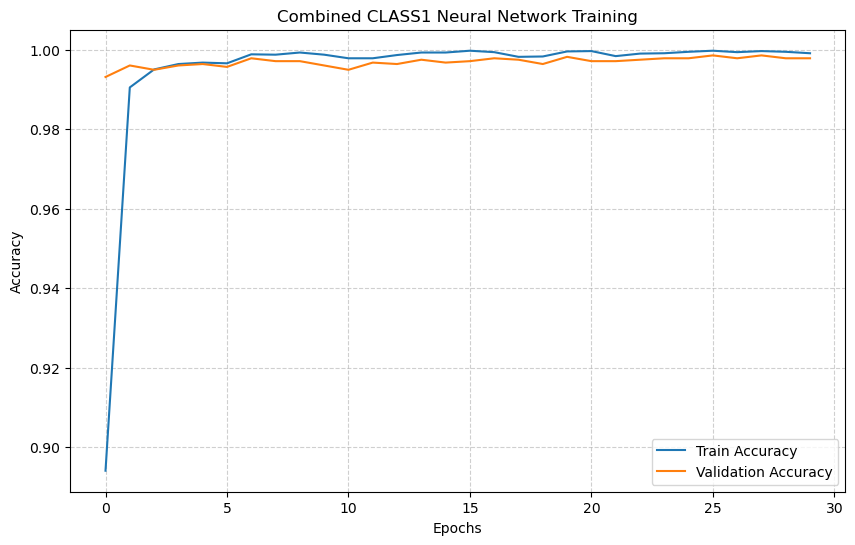

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/30


C:\Users\pharp\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5101 - loss: 1.5475 - val_accuracy: 0.9743 - val_loss: 0.1141
Epoch 2/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9507 - loss: 0.1826 - val_accuracy: 0.9902 - val_loss: 0.0366
Epoch 3/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9832 - loss: 0.0656 - val_accuracy: 0.9924 - val_loss: 0.0276
Epoch 4/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9881 - loss: 0.0436 - val_accuracy: 0.9931 - val_loss: 0.0240
Epoch 5/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9917 - loss: 0.0299 - val_accuracy: 0.9953 - val_loss: 0.0162
Epoch 6/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9958 - loss: 0.0183 - val_accuracy: 0.9949 - val_loss: 0.0188
Epoch 7/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9956 - loss: 0.0145 - val_accuracy: 0.9953 - val_loss: 0.0146
Epoch 8/30
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9944 - loss: 0.0192 - val_accuracy: 0.9960 - va

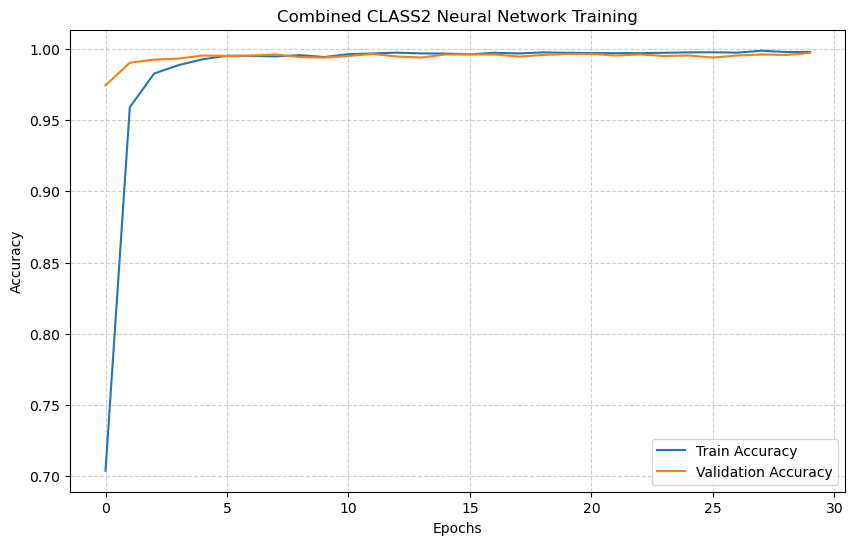

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [17]:
combined_nn_class_1_pred, combined_nn_class_1_real = train_evaluate_and_plot_nn(
    X_train_combined, X_test_combined, y_train_combined_class1, y_test_combined_class1, "Combined CLASS1"
)
combined_nn_class_2_pred, combined_nn_class_2_real = train_evaluate_and_plot_nn(
    X_train_combined, X_test_combined, y_train_combined_class2, y_test_combined_class2, "Combined CLASS2"
)

## t-sne

In [18]:
def plot_tsne_real(X_test, y_test, label):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_results = tsne.fit_transform(X_test)

    tsne_plot = plt.figure(figsize=(10, 6))
    ax = tsne_plot.add_subplot(111)
    for unique_label in np.unique(y_test):
        indices = np.where(y_test == unique_label)
        ax.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=f'Class {unique_label}', alpha=0.7)
    ax.legend()
    plt.close(tsne_plot)

    return tsne_plot

In [19]:
audio_real_class_1 = plot_tsne_real(X_test_audio, y_test_audio_class1, "Audio CLASS1")
audio_real_class_2 = plot_tsne_real(X_test_audio, y_test_audio_class2, "Audio CLASS2")
image_real_class_1 = plot_tsne_real(X_test_image, y_test_image_class1, "Image CLASS1")
image_real_class_2 = plot_tsne_real(X_test_image, y_test_image_class2, "Image CLASS2")
combined_real_class_1 = plot_tsne_real(X_test_combined, y_test_combined_class1, "Combined CLASS1")
combined_real_class_2 = plot_tsne_real(X_test_combined, y_test_combined_class2, "Combined CLASS2")

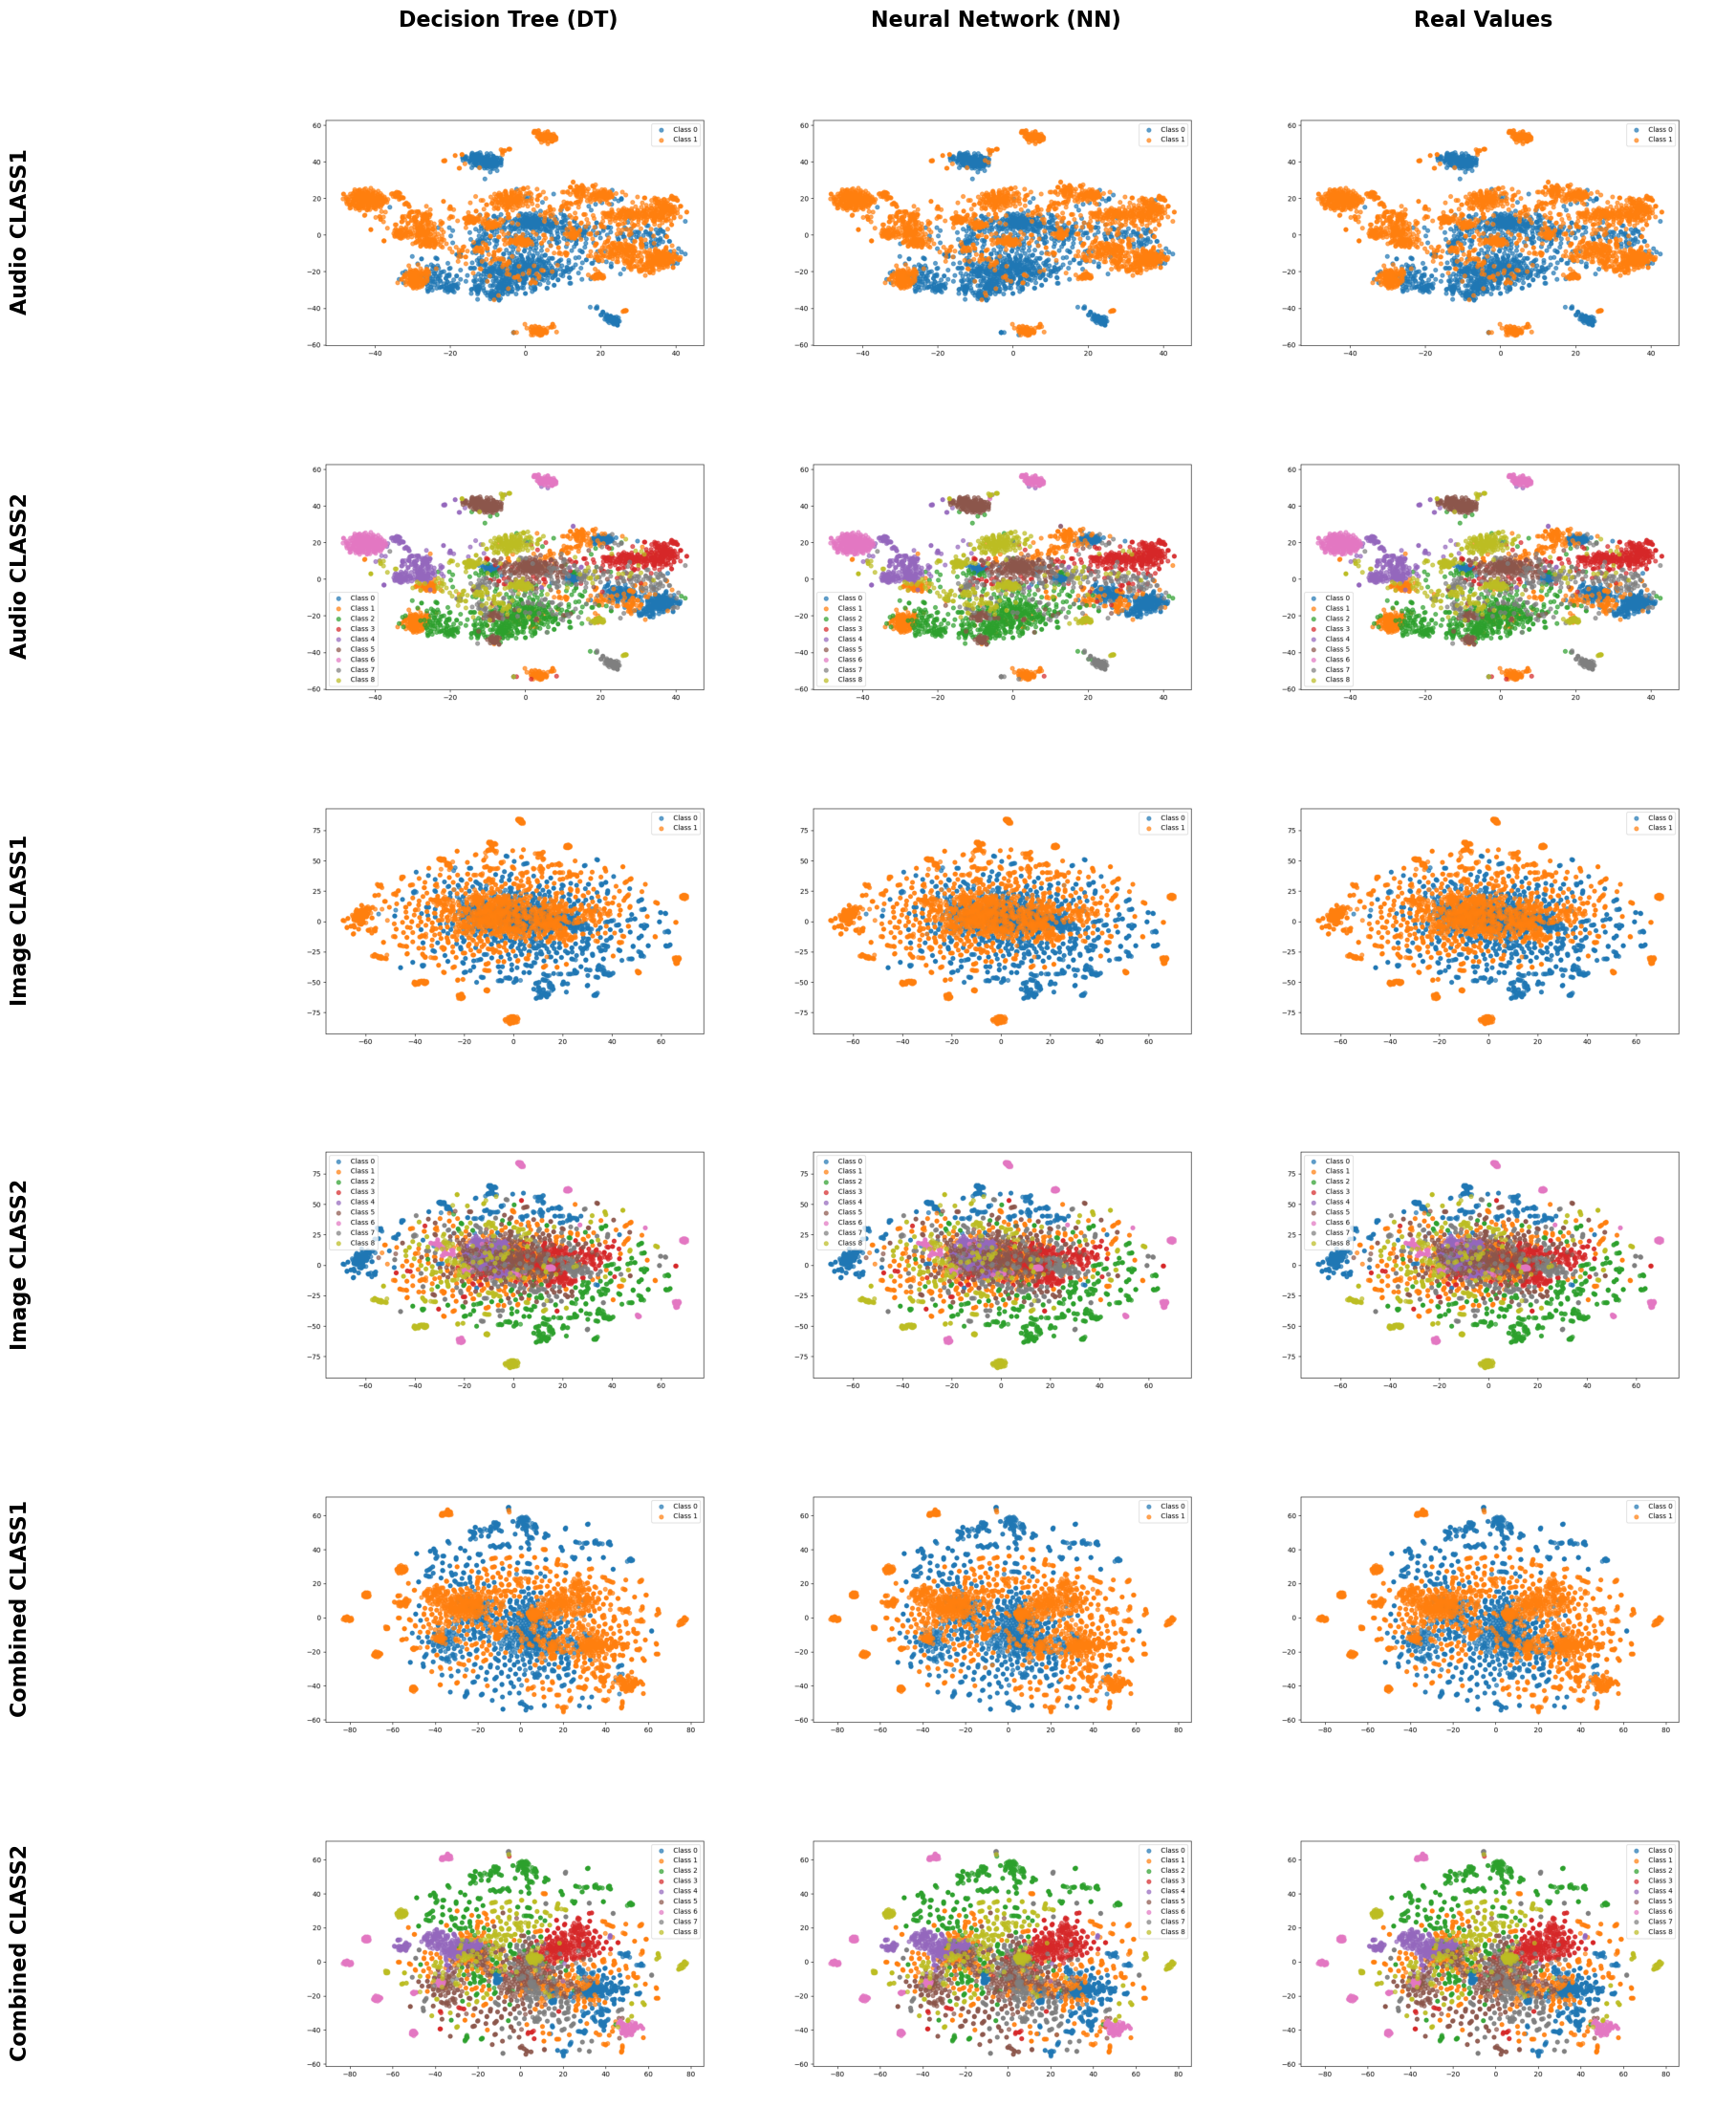

In [21]:
def figure_to_image(fig):
    canvas = FigureCanvas(fig)
    canvas.draw()
    width, height = canvas.get_width_height()
    buffer = np.frombuffer(canvas.tostring_argb(), dtype=np.uint8).reshape(height, width, 4)
    image = buffer[:, :, 1:]
    return image

plots = [
    (audio_dt_class_1, audio_nn_class_1_pred, audio_real_class_1),  # Audio CLASS1
    (audio_dt_class_2, audio_nn_class_2_pred, audio_real_class_2),  # Audio CLASS2
    (image_dt_class_1, image_nn_class_1_pred, image_real_class_1),  # Image CLASS1
    (image_dt_class_2, image_nn_class_2_pred, image_real_class_2),  # Image CLASS2
    (combined_dt_class_1, combined_nn_class_1_pred, combined_real_class_1),
    (combined_dt_class_2, combined_nn_class_2_pred, combined_real_class_2),
]

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(18, 24), gridspec_kw={'wspace': 0, 'hspace': 0})

column_titles = ['Decision Tree (DT)', 'Neural Network (NN)', 'Real Values']
for col, title in enumerate(column_titles):
    axes[0, col].annotate(title, xy=(0.5, 1.2), xycoords='axes fraction', ha='center', fontsize=16, weight='bold')

row_titles = ['Audio CLASS1', 'Audio CLASS2', 'Image CLASS1', 'Image CLASS2', 'Combined CLASS1', 'Combined CLASS2']
for i, (dt_plot, nn_plot, real_plot) in enumerate(plots):

    dt_image = figure_to_image(dt_plot)
    axes[i, 0].imshow(dt_image)
    axes[i, 0].axis('off')

    nn_image = figure_to_image(nn_plot)
    axes[i, 1].imshow(nn_image)
    axes[i, 1].axis('off')

    real_image = figure_to_image(real_plot)
    axes[i, 2].imshow(real_image)
    axes[i, 2].axis('off')

    axes[i, 0].annotate(row_titles[i], xy=(-0.5, 0.5), xycoords='axes fraction', ha='center', va='center',
                         rotation=90, fontsize=16, weight='bold')

plt.subplots_adjust(top=0.95, bottom=0.05, left=0.1, right=0.95)
plt.show()

The table shows that both the Decision Tree (DT) and Neural Network (NN) achieve high accuracy, as the T-SNE plots for predictions closely match the real labels, indicating effective class separation and strong classification performance.